In [1]:
import pandas as pd
import numpy as np

# Carga de datos

In [138]:
import pickle

with open("./Datasets/China/X_train_China.pkl", "rb") as archivo:
    ppg_signals = pickle.load(archivo).values 

with open("./Datasets/China/y_train_China.pkl", "rb") as archivo:
    y_labels = pickle.load(archivo).squeeze()

print(type(ppg_signals), ppg_signals.shape)
print(type(y_labels), y_labels.shape)

<class 'numpy.ndarray'> (459, 2100)
<class 'pandas.core.series.Series'> (459,)


In [139]:
def moving_average(signal, window_size=50):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# Convertir cada fila del DataFrame en un arreglo de NumPy y aplicar el suavizado
ppg_signals = np.array([moving_average(ppg_signal) for ppg_signal in ppg_signals])

# Normalizaci√≥n Min-Max
def normalize_min_max(signals):
    # Calcular m√≠nimos y m√°ximos por fila
    min_vals = np.min(signals, axis=1, keepdims=True)
    max_vals = np.max(signals, axis=1, keepdims=True)
    # Normalizar cada fila
    return (signals - min_vals) / (max_vals - min_vals)

ppg_signals = normalize_min_max(ppg_signals)

# Aplicar EMD a una se√±al de ejemplo

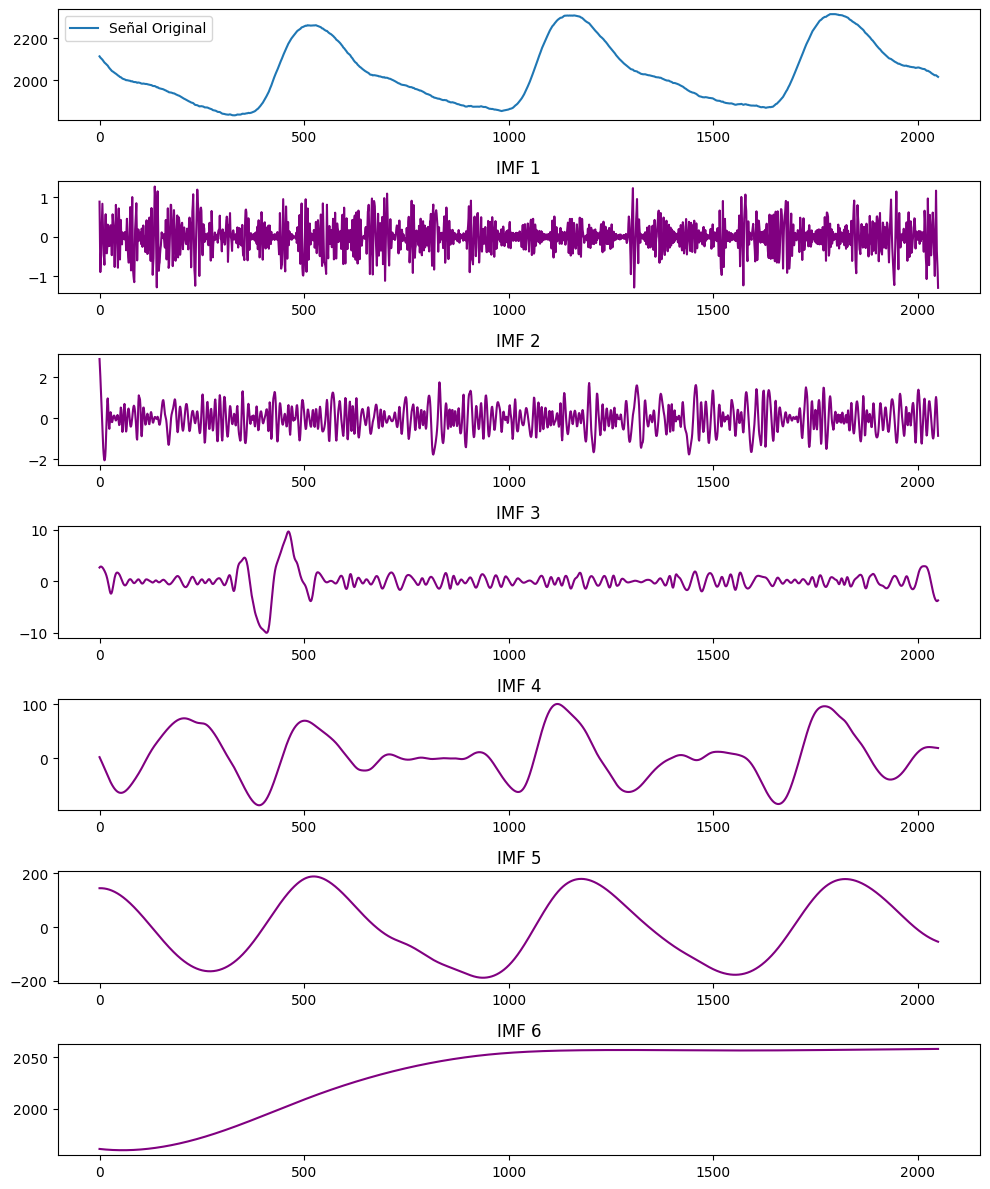

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD

# Seleccionamos una se√±al de ejemplo
idx = 1  
signal = ppg_signals[idx]  

# Aplicamos EMD
emd = EMD()
imfs = emd(signal)

# Visualizamos la se√±al original y sus IMFs
plt.figure(figsize=(10, len(imfs)*2))
plt.subplot(len(imfs) + 1, 1, 1)
plt.plot(signal, label="Se√±al Original")
plt.legend()

for i in range(len(imfs)):
    plt.subplot(len(imfs) + 1, 1, i + 2)
    plt.plot(imfs[i], color="purple")
    plt.title(f"IMF {i+1}")

plt.tight_layout()
plt.show()

# Aplicar EMD a todas las se√±ales del conjunto

In [140]:
import numpy as np
import pandas as pd
from collections import defaultdict
from PyEMD import EMD  

num_frames, num_samples = ppg_signals.shape

# Configuraci√≥n √≥ptima encontrada
#fixe_value = 70
#fixe_h_value = 1
#max_iterations = 100  # N√∫mero m√°ximo de iteraciones

# Diccionario para contar cu√°ntas se√±ales tienen cierta cantidad de IMFs
imf_counts = defaultdict(list)  # {num_imfs: [√≠ndices de se√±ales]}

# Aplicamos EMD a cada se√±al y registramos cu√°ntas IMFs genera
imf_list = []  # Para almacenar las IMFs de cada se√±al

for idx, signal in enumerate(ppg_signals):
    emd = EMD()
    
    # Ajustamos los par√°metros de la EMD
    #emd.FIXE = fixe_value
    #emd.FIXE_H = fixe_h_value
    #emd.MAX_ITERATION = max_iterations

    # Ejecutamos la descomposici√≥n
    imfs = emd.emd(signal)
    
    # Guardamos el n√∫mero de IMFs y su √≠ndice
    num_imfs = imfs.shape[0]
    imf_counts[num_imfs].append(idx)  # Asigna el √≠ndice de la se√±al a su cantidad de IMFs
    imf_list.append(imfs)  # Guardamos los IMFs para futuras visualizaciones

# Convertimos el diccionario en un DataFrame para visualizar mejor
imf_summary = pd.DataFrame([(k, len(v)) for k, v in imf_counts.items()], columns=["Num_IMFs", "Cantidad_Se√±ales"])

# Ordenamos los datos por n√∫mero de IMFs
imf_summary = imf_summary.sort_values(by="Num_IMFs")

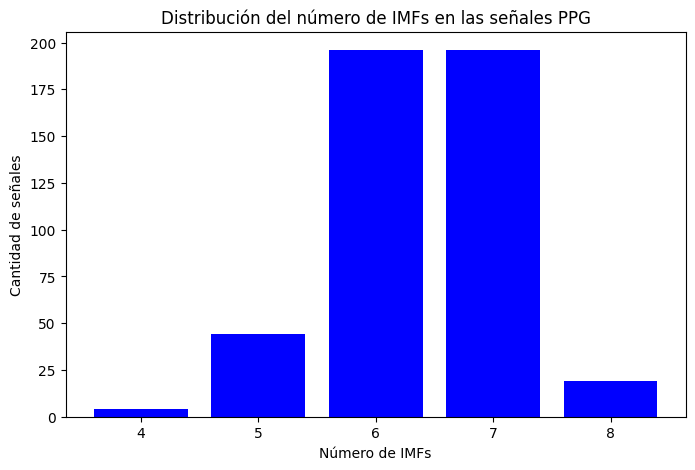

In [141]:
import matplotlib.pyplot as plt
# Visualizamos los resultados en un histograma
plt.figure(figsize=(8, 5))
plt.bar(imf_summary["Num_IMFs"], imf_summary["Cantidad_Se√±ales"], color='blue')
plt.xlabel("N√∫mero de IMFs")
plt.ylabel("Cantidad de se√±ales")
plt.title("Distribuci√≥n del n√∫mero de IMFs en las se√±ales PPG")
plt.xticks(imf_summary["Num_IMFs"])
plt.show()

# An√°lisis frecuencial de las IMF

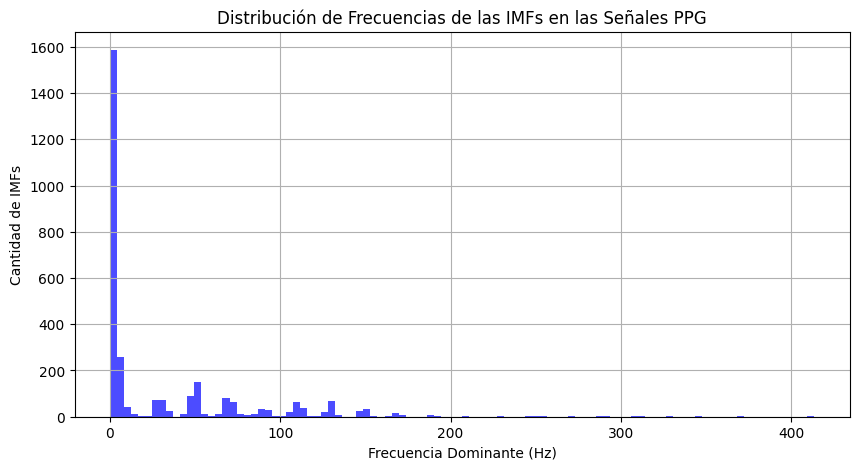

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Par√°metros de la se√±al
fs = 1000  # Frecuencia de muestreo (1 kHz)
n_samples = ppg_signals.shape[1] 
t = np.linspace(0, n_samples/fs, n_samples, endpoint=False)  # Vector de tiempo

# Lista para almacenar frecuencias de IMFs
imf_frequencies = []
signal_labels = []
imf_numbers = []

for idx in range(len(ppg_signals)):
    imfs = imf_list[idx]  # Extraemos las IMFs de la se√±al

    for i, imf in enumerate(imfs):
        # Aplicamos FFT a la IMF
        imf_fft = np.abs(fft(imf))[:n_samples // 2]
        freqs = fftfreq(n_samples, d=1/fs)[:n_samples // 2]

        # Frecuencia dominante
        dominant_freq = freqs[np.argmax(imf_fft)]

        # Guardamos los resultados
        imf_frequencies.append(dominant_freq)
        signal_labels.append(idx)
        imf_numbers.append(i + 1)  # N√∫mero de IMF

# Convertimos en DataFrame para an√°lisis
df_imfs = pd.DataFrame({"Se√±al": signal_labels, "IMF": imf_numbers, "Frecuencia": imf_frequencies})
avg_frequencies = df_imfs.groupby("Se√±al")["Frecuencia"].apply(list).to_dict()

# Visualizamos la distribuci√≥n de frecuencias
plt.figure(figsize=(10, 5))
plt.hist(imf_frequencies, bins=100, color='blue', alpha=0.7)
plt.xlabel("Frecuencia Dominante (Hz)")
plt.ylabel("Cantidad de IMFs")
plt.title("Distribuci√≥n de Frecuencias de las IMFs en las Se√±ales PPG")
plt.grid()
plt.show()

## Funciones para graficar el espectro con cluster agrupados (K-means) y recomposicion de las IMF de las se√±ales

In [11]:
import seaborn as sns
from sklearn.cluster import KMeans

def calculate_adjusted_ranges_with_clustering_and_limits(
    avg_frequencies, num_clusters=5, frequency_limits=(0.25, 4)
):
    """
    Calcula rangos de frecuencia ajustados con clustering dentro de l√≠mites definidos.

    Parameters:
        avg_frequencies: Diccionario {signal_index: [frecuencias promedio de IMFs]}.
        num_clusters: N√∫mero de clusters (rangos) dentro del l√≠mite definido.
        frequency_limits: Tupla (min_limit, max_limit) con los l√≠mites para el clustering.

    Returns:
        adjusted_ranges: Lista de tuplas (min, max) con los rangos ajustados.
        all_frequencies: Lista de todas las frecuencias sin ceros.
        below_limit: Frecuencias por debajo del l√≠mite inferior.
        above_limit: Frecuencias por encima del l√≠mite superior.
    """
    min_limit, max_limit = frequency_limits

    # Convertir el diccionario en una lista de frecuencias, ignorando ceros
    all_frequencies = np.hstack([np.array(freqs) for freqs in avg_frequencies.values() if len(freqs) > 0])
    all_frequencies = all_frequencies[all_frequencies > 0]  # Filtrar ceros

    # Filtrar frecuencias fuera de los l√≠mites
    below_limit = all_frequencies[all_frequencies < min_limit]
    above_limit = all_frequencies[all_frequencies > max_limit]
    in_range_frequencies = all_frequencies[(all_frequencies >= min_limit) & (all_frequencies <= max_limit)]

    # Aplicar K-Means a las frecuencias dentro del rango
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(in_range_frequencies.reshape(-1, 1))
    centroids = np.sort(kmeans.cluster_centers_.flatten())

    # Generar rangos con los centroides
    adjusted_ranges = [(min_limit, centroids[0])]  # Primer rango desde min_limit
    for i in range(len(centroids) - 1):
        adjusted_ranges.append((centroids[i], centroids[i + 1]))
    adjusted_ranges.append((centroids[-1], max_limit))  # √öltimo rango hasta max_limit

    # Agregar los rangos extremos
    adjusted_ranges = [(0, min_limit)] + adjusted_ranges + [(max_limit, np.inf)]

    return adjusted_ranges, all_frequencies, below_limit, above_limit


def plot_range_spectrum_with_limits(
    adjusted_ranges, all_frequencies, frequency_limits, xlim=(0, 1000), bins=100, ylim=(0,100)
):
    """
    Visualiza los rangos ajustados en el histograma con l√≠neas de los l√≠mites definidos.

    Parameters:
        adjusted_ranges: Lista de rangos ajustados.
        all_frequencies: Lista de todas las frecuencias no nulas.
        frequency_limits: Tupla (min_limit, max_limit) con los l√≠mites del clustering.
        xlim: Tupla que define los l√≠mites del eje x.
        bins: N√∫mero de bins para el histograma.
    """
    plt.figure(figsize=(12, 5))
    colors = sns.color_palette("husl", len(adjusted_ranges))  # Asignar colores

    plt.hist(all_frequencies, bins=bins, color='skyblue', alpha=0.7, label='Frecuencias promedio')

    # Dibujar los l√≠mites definidos con l√≠neas verticales
    min_limit, max_limit = frequency_limits
    plt.axvline(min_limit, color='red', linestyle='--', label=f'L√≠mite inferior: {min_limit:.2f} Hz')
    plt.axvline(max_limit, color='red', linestyle='--', label=f'L√≠mite superior: {max_limit:.2f} Hz')

    # Sombrear los rangos de frecuencia ajustados
    for i, (low, high) in enumerate(adjusted_ranges):
        if high < xlim[0] or low > xlim[1]:
            continue  # Ignorar rangos fuera del l√≠mite de visualizaci√≥n
        plt.axvspan(max(low, xlim[0]), min(high, xlim[1]), alpha=0.3, color=colors[i], label=f'Rango: {low:.2f}-{high:.2f}')

    plt.xlabel("Frecuencia promedio (Hz)")
    plt.xlim(xlim)  # Ajustar l√≠mites del eje x
    #plt.ylim(ylim)
    plt.xticks(np.linspace(xlim[0], xlim[1], num=16))  # Ajustar etiquetas del eje x
    plt.ylabel("N√∫mero de IMFs")
    plt.title("Rangos de frecuencia ajustados con l√≠mites definidos")
    plt.legend(loc="upper right", fontsize=8)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

def reorganize_and_fill_imfs(imfs_list, adjusted_ranges, frequencies):
    """
    Reorganiza y completa las IMFs de cada se√±al para que tengan un n√∫mero fijo de IMFs.
    Calcula la frecuencia promedio de cada IMF, la asigna al rango correspondiente y organiza las IMFs.
    Si varias IMFs caen en el mismo rango, se suman. Si un rango no tiene IMFs, se rellena con ceros.

    Parameters:
        imfs_list: Lista de numpy arrays, donde cada array tiene las IMFs de una se√±al (n_imfs, n_samples).
        adjusted_ranges: Lista de tuplas (min, max) con los rangos de frecuencia ajustados.
        frequencies: Diccionario {signal_index: [frecuencias promedio de IMFs]}.

    Returns:
        reorganized_imfs: numpy array de forma (n_signals, num_ranges + 1, n_samples) con las IMFs reorganizadas.
                          El √≠ndice 0 corresponde a la componente residual o base.
    """
    num_ranges = len(adjusted_ranges)  # N√∫mero de rangos fijos
    n_signals = len(imfs_list)  # N√∫mero de se√±ales
    n_samples = imfs_list[0].shape[1]  # N√∫mero de muestras por se√±al

    # Inicializar la matriz reorganizada con ceros (incluye un rango adicional para la tendencia/base en el √≠ndice 0)
    reorganized_imfs = np.zeros((n_signals, num_ranges + 1, n_samples))

    for signal_idx, (signal_imfs, signal_freqs) in enumerate(zip(imfs_list, frequencies.values())):
        for imf, freq in zip(signal_imfs, signal_freqs):
            # Encontrar el rango correspondiente para la IMF actual
            assigned = False
            for i, (low, high) in enumerate(adjusted_ranges):
                if low < freq <= high:
                    reorganized_imfs[signal_idx, i + 1, :] += imf  # Sumar la IMF al rango correspondiente
                    assigned = True
                    break

                
            # Si no se asign√≥ a ning√∫n rango, se considera parte de la componente base
            if not assigned:
                reorganized_imfs[signal_idx, 0, :] += imf

    return reorganized_imfs



def plot_reorganized_imfs(signal_indices, original_signals, reorganized_imfs, adjusted_ranges):
    """
    Grafica se√±ales originales y sus IMFs reorganizadas con colores seg√∫n el rango de frecuencia.

    Par√°metros:
        signal_indices: Lista de √≠ndices de se√±ales a graficar.
        original_signals: Lista o array con las se√±ales originales.
        reorganized_imfs: Array (n_signals, num_ranges + 1, n_samples) con las IMFs reorganizadas.
                          El √≠ndice 0 corresponde a la componente residual o base.
        adjusted_ranges: Lista de tuplas con los rangos de frecuencia [(min, max)].
    """
    num_signals = len(signal_indices)
    num_imfs = reorganized_imfs.shape[1]  # N√∫mero de IMFs reorganizadas

    fig, axes = plt.subplots(num_signals, num_imfs + 2, figsize=(30, 3 * num_signals), sharex=True)

    # Definir colores para cada rango de frecuencia
    colors = sns.color_palette("husl", num_imfs - 1)

    for i, signal_idx in enumerate(signal_indices):
        # Gr√°fico de la se√±al original
        axes[i, 0].plot(original_signals[signal_idx], color="black", label=f"Se√±al Original - √çndice {signal_idx}")
        axes[i, 0].legend(loc="upper left", fontsize=10, frameon=True)

        # Graficamos la componente residual o base
        axes[i, 1].plot(reorganized_imfs[signal_idx, 0, :], color="purple", label="Componente Residual/Base")
        axes[i, 1].legend(loc="upper left", fontsize=10, frameon=True)

        # Graficamos las IMFs reorganizadas con el color correspondiente al rango de frecuencia
        for j in range(1, num_imfs):
            axes[i, j + 1].plot(reorganized_imfs[signal_idx, j, :], color=colors[j - 1], label=f"IMF {j}\n({adjusted_ranges[j - 1][0]:.2f}-{adjusted_ranges[j - 1][1]:.2f} Hz)")
            axes[i, j + 1].legend(loc="upper left", fontsize=10, frameon=True)

        # Se√±al reconstruida sumando las IMFs reorganizadas
        reconstructed_signal = np.sum(reorganized_imfs[signal_idx], axis=0)
        axes[i, -1].plot(reconstructed_signal, color="red", label=f"Se√±al Reconstruida - √çndice {signal_idx}")
        axes[i, -1].legend(loc="upper left", fontsize=10, frameon=True)

    plt.tight_layout()
    plt.show()


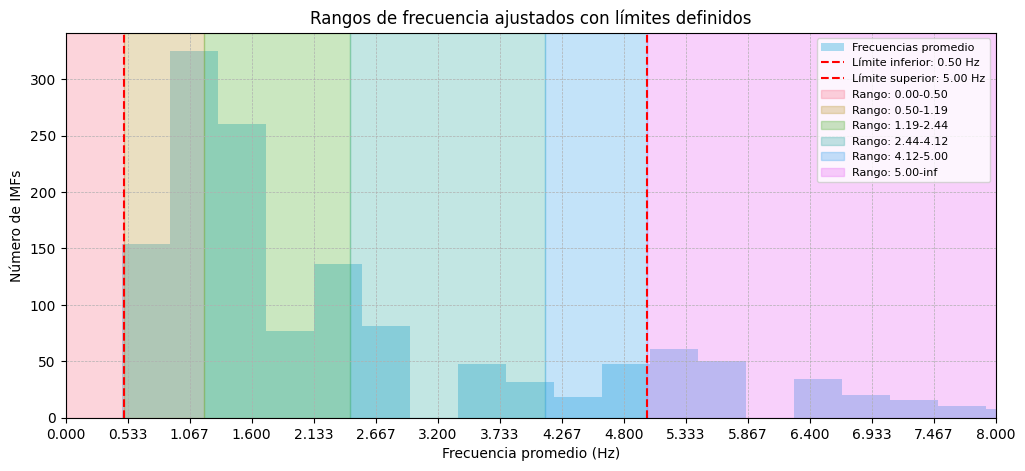

In [143]:
# Par√°metros personalizados
frequency_limits = (0.5, 5)  # Definir el rango de aplicaci√≥n de K-Means
num_clusters_fq = 3 # Ajustar el n√∫mero de clusters

# Aplicar el clustering de frecuencias dentro del rango definido
adjusted_ranges_clustering, all_frequencies, below_limit, above_limit = calculate_adjusted_ranges_with_clustering_and_limits(
    avg_frequencies, num_clusters=num_clusters_fq, frequency_limits=frequency_limits
)

# Graficar los nuevos rangos de frecuencia ajustados
plot_range_spectrum_with_limits(adjusted_ranges_clustering, all_frequencies, frequency_limits, xlim=(0, 8), bins=1000)

In [144]:
reorganized_imfs = reorganize_and_fill_imfs(imf_list, adjusted_ranges_clustering, avg_frequencies)

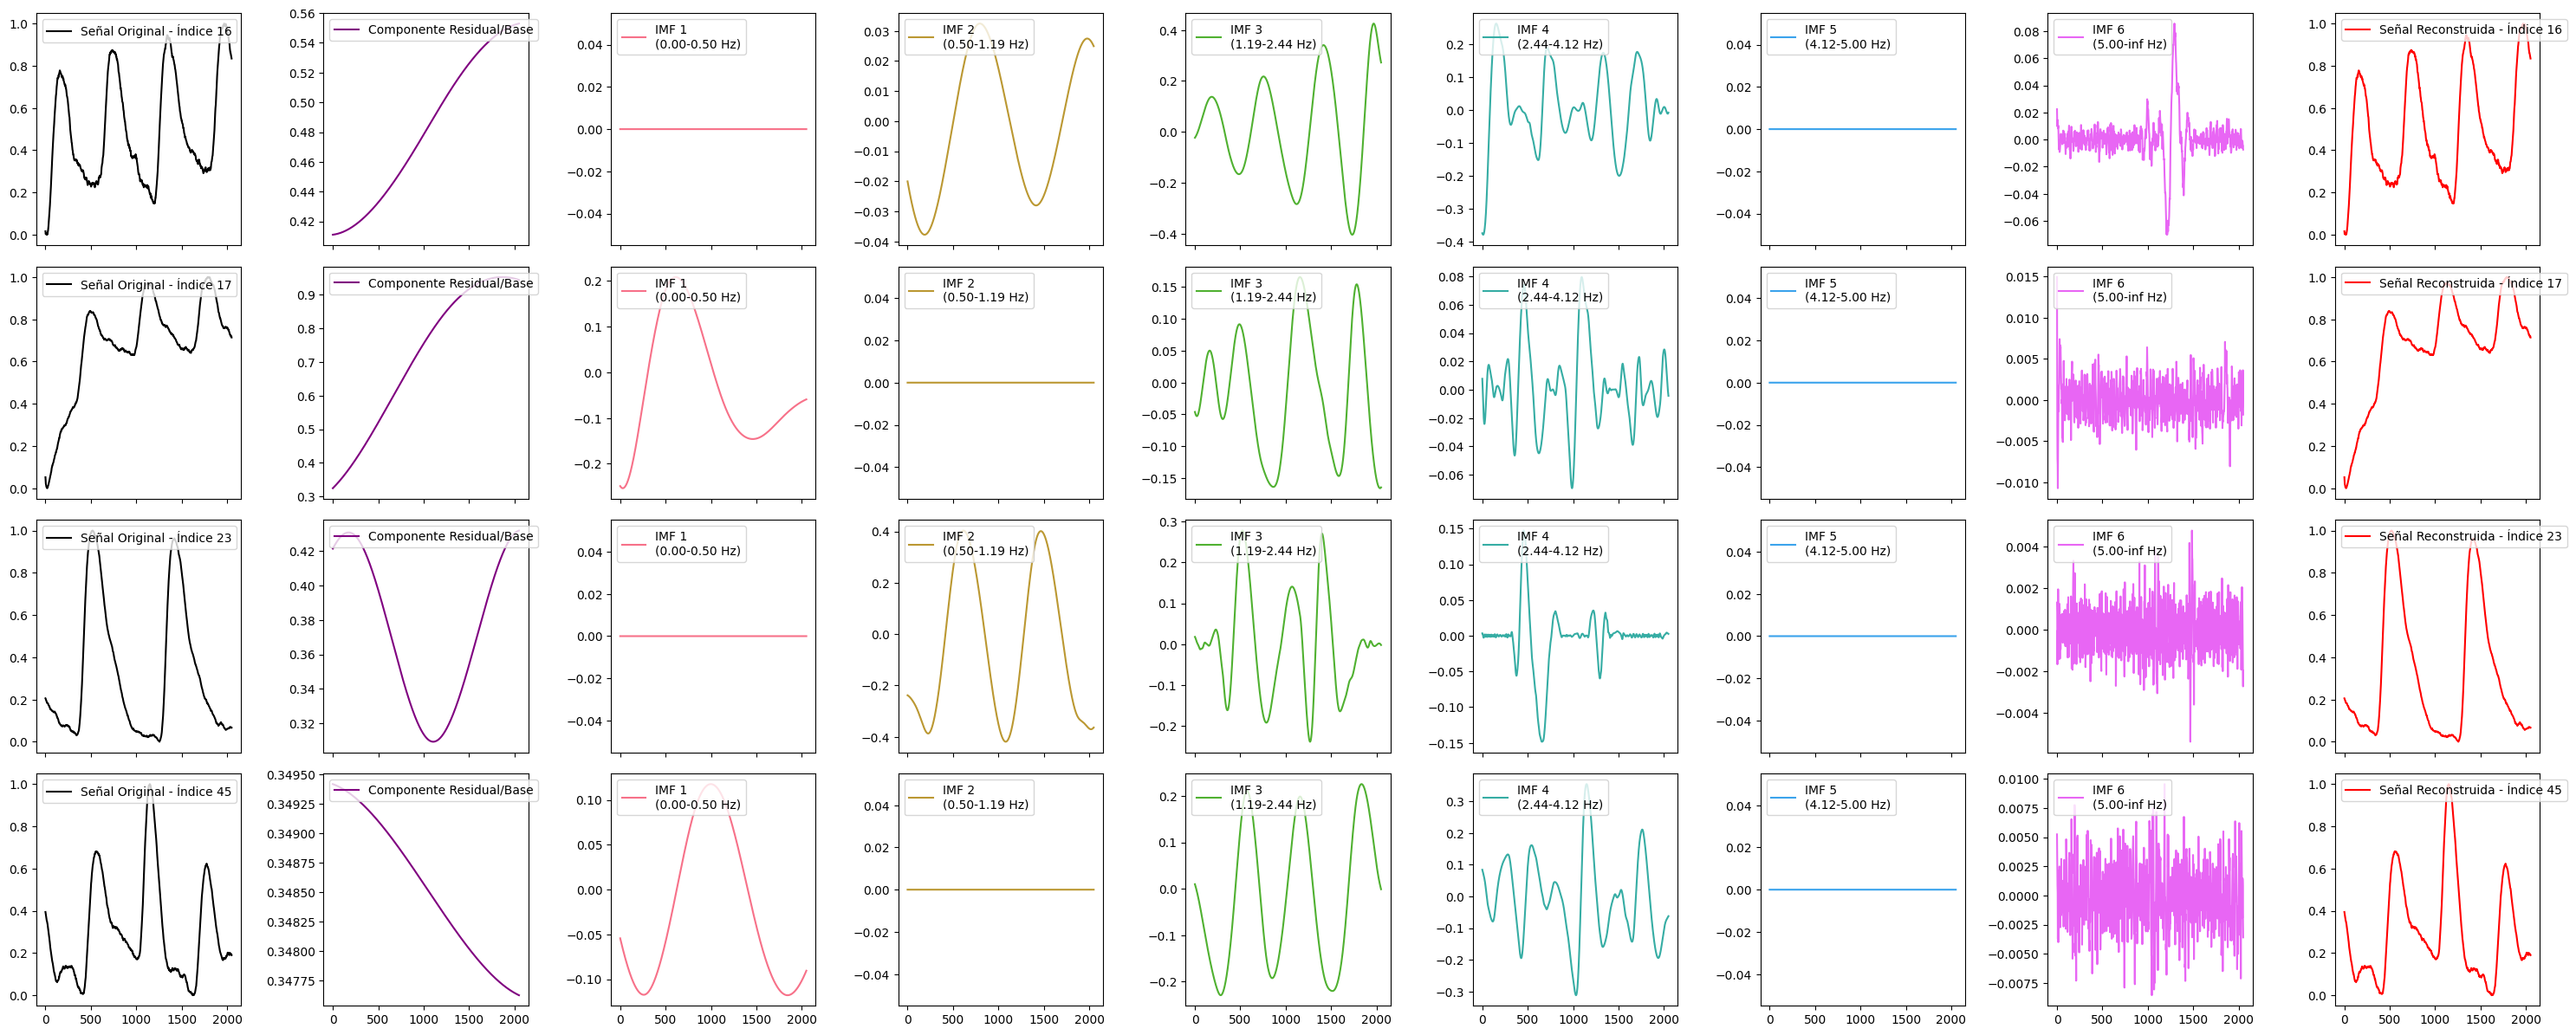

Se√±ales con IMF en el √≠ndice 0: 459
Se√±ales con IMF en el √≠ndice 1: 143
Se√±ales con IMF en el √≠ndice 2: 270
Se√±ales con IMF en el √≠ndice 3: 369
Se√±ales con IMF en el √≠ndice 4: 151
Se√±ales con IMF en el √≠ndice 5: 66
Se√±ales con IMF en el √≠ndice 6: 459


In [145]:
selected_signal_indices = [16,17,23,45]  # Puedes cambiar los √≠ndices
plot_reorganized_imfs(selected_signal_indices, ppg_signals, reorganized_imfs, adjusted_ranges_clustering)
for i in range(reorganized_imfs.shape[1]):
    print(f"Se√±ales con IMF en el √≠ndice {i}: {np.sum(np.any(reorganized_imfs[:, i, :] != 0, axis=1))}")

In [146]:
summed_imfs = reorganized_imfs.copy() 
summed_imfs[:,4,:] += summed_imfs[:,5,:] #Sumamos la IMF5 a la IMF 4
summed_imfs = np.delete(summed_imfs, 6, axis=1) #Eliminamos la IMF 6
summed_imfs = np.delete(summed_imfs, 5, axis=1) #Eliminamos la IMF 5

summed_imfs[:,1,:] += summed_imfs[:,0,:]
summed_imfs = np.delete(summed_imfs, 0, axis=1)

summed_imfs.shape

(459, 4, 2051)

In [147]:
adjusted_ranges_clustering

[(0, 0.5),
 (0.5, np.float64(1.1918305433663776)),
 (np.float64(1.1918305433663776), np.float64(2.4444687675167573)),
 (np.float64(2.4444687675167573), np.float64(4.120943342038297)),
 (np.float64(4.120943342038297), 5),
 (5, inf)]

In [148]:
adjusted_ranges_clustering_new = [(0, np.float64(1.1850931677018628)),
 (np.float64(1.1850931677018628), np.float64(2.405632984901277)),
 (np.float64(2.405632984901277), 5)]

In [149]:
# üîπ Lista para almacenar los √≠ndices de se√±ales sin ninguna IMF en cero
valid_signals = []

#for idx in similar_signals_indices:  # Iteramos sobre los √≠ndices seleccionados
for idx in range(len(summed_imfs)):
    if np.all(summed_imfs[idx] != 0):  # Verifica si TODAS las IMFs de la se√±al tienen valores distintos de 0
        valid_signals.append(idx)

# üîπ Convertimos a un array numpy
valid_signals = np.array(valid_signals)

print(f"‚úÖ Se han encontrado {len(valid_signals)} se√±ales sin IMFs nulas.")
print(f"üìå √çndices de se√±ales seleccionadas: {valid_signals}")

‚úÖ Se han encontrado 61 se√±ales sin IMFs nulas.
üìå √çndices de se√±ales seleccionadas: [ 16  19  21  23  26  28  40  47  59  62  63  69  91  92  96 122 124 134
 137 142 144 146 158 164 165 167 179 188 190 209 235 238 242 249 250 264
 271 272 278 280 281 304 316 359 374 381 385 389 396 401 402 403 422 430
 432 433 434 440 452 456 458]


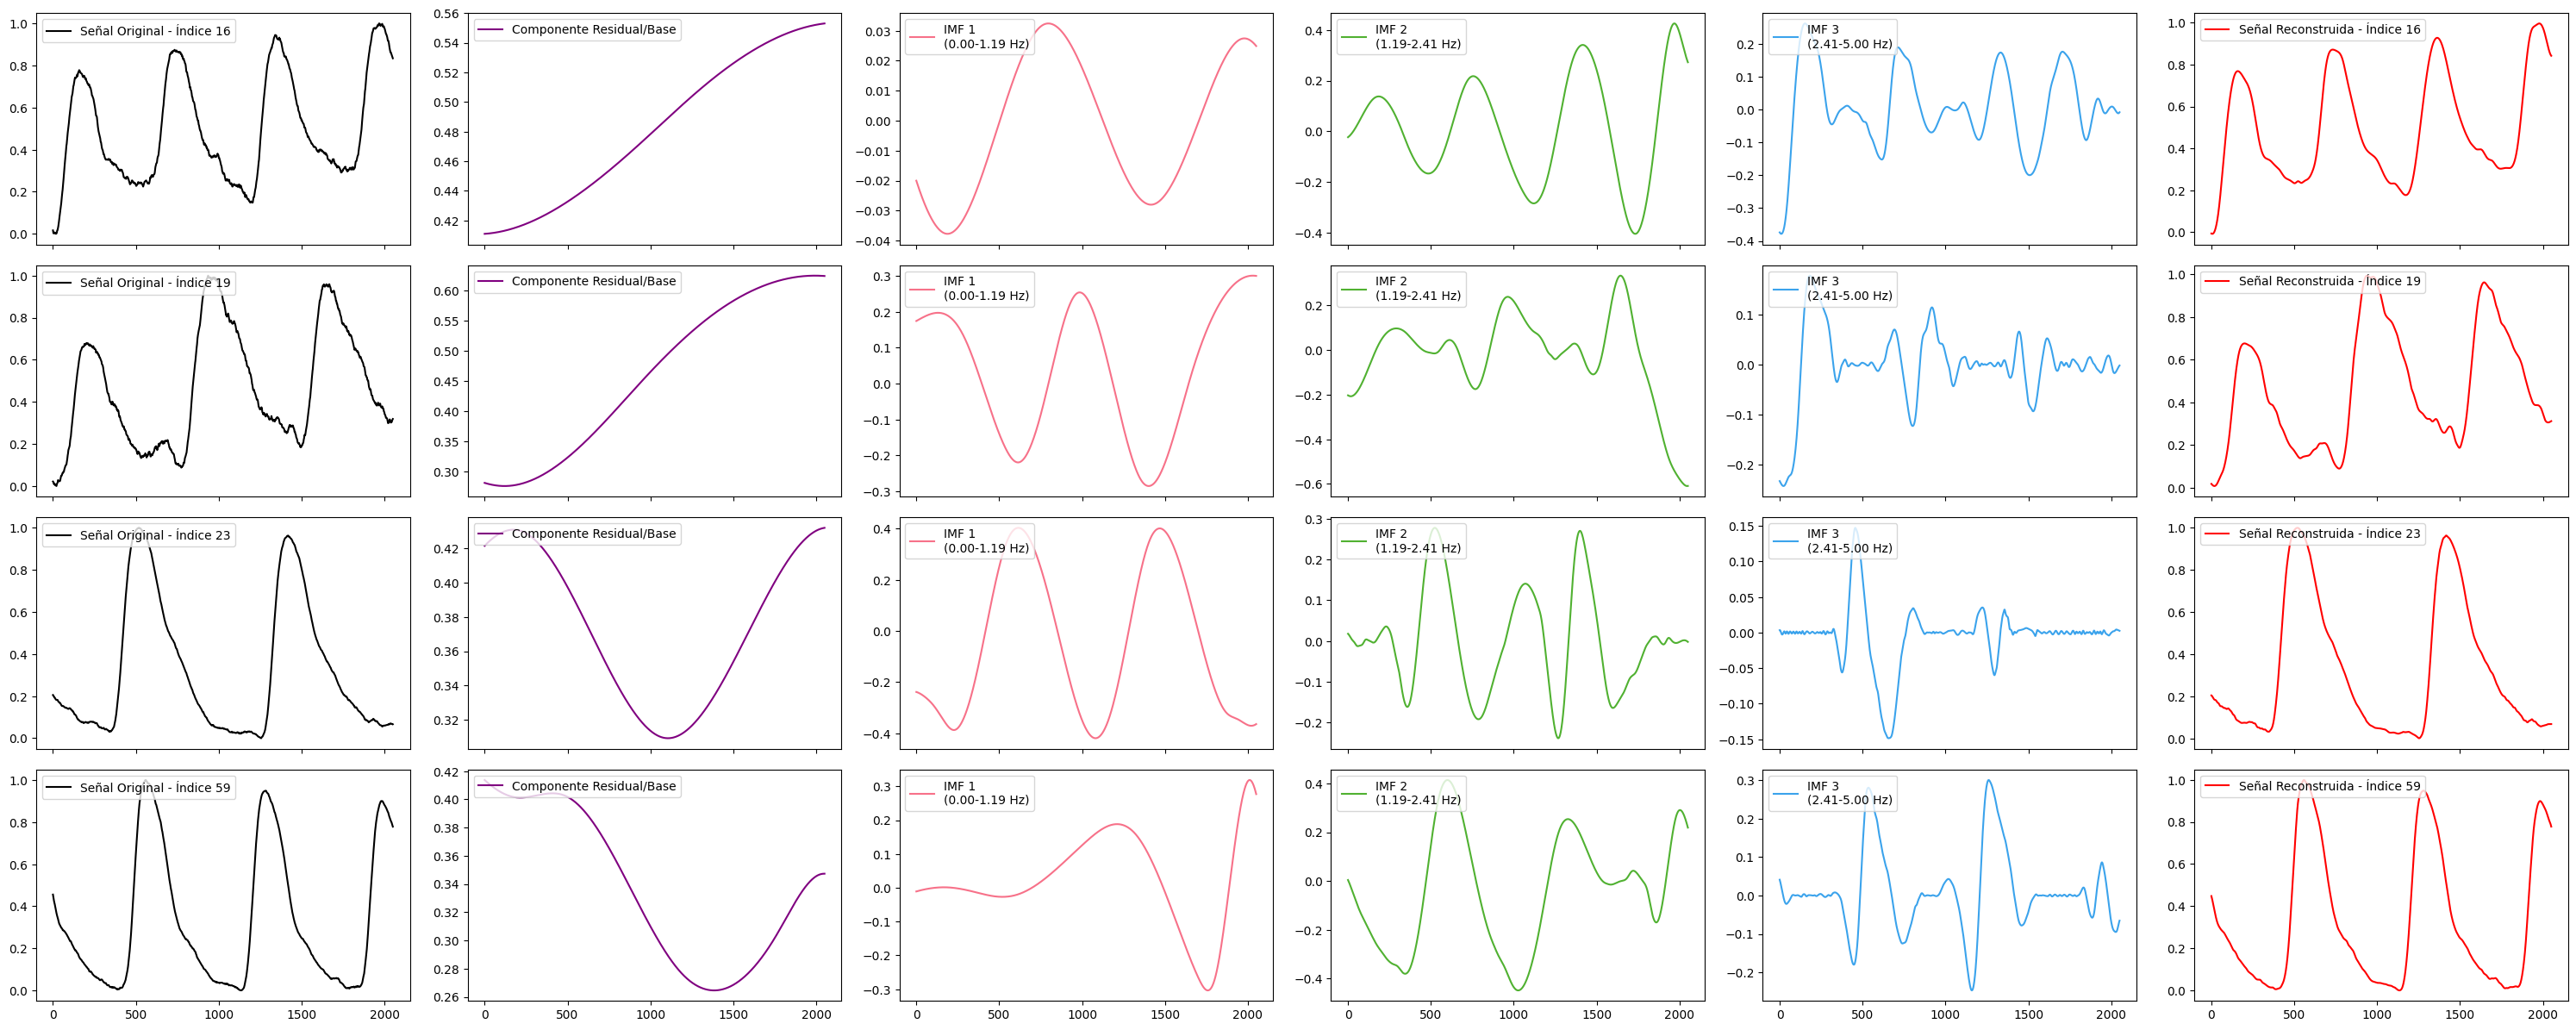

Se√±ales con IMF en el √≠ndice 0: 459
Se√±ales con IMF en el √≠ndice 1: 270
Se√±ales con IMF en el √≠ndice 2: 369
Se√±ales con IMF en el √≠ndice 3: 200


In [150]:
selected_signal_indices = [16,19,23,59]  # Puedes cambiar los √≠ndices
plot_reorganized_imfs(selected_signal_indices, ppg_signals, summed_imfs, adjusted_ranges_clustering_new)
for i in range(summed_imfs.shape[1]):
    print(f"Se√±ales con IMF en el √≠ndice {i}: {np.sum(np.any(summed_imfs[:, i, :] != 0, axis=1))}")

# Data Augmentation

In [151]:
signals_imfs = summed_imfs
labels = y_labels
num_true = int(np.sum(labels))
num_false = len(labels) - num_true

print(f"‚úÖ N√∫mero de True: {num_true}")
print(f"‚úÖ N√∫mero de False: {num_false}")

‚úÖ N√∫mero de True: 168
‚úÖ N√∫mero de False: 291


In [129]:
def create_artificial_frame_v2(signals_imfs: np.array, labels: np.array, num_synthetic_per_class=[500, 500], set_real_IMFs_idx=None):
    """
    Genera se√±ales sint√©ticas combinando IMFs de se√±ales originales de la misma clase,
    evitando IMFs que sean completamente ceros y buscando reemplazo dentro de otra se√±al de la misma clase.

    Par√°metros:
        signals_imfs: np.array de forma (num_signals, num_imfs, num_samples) con las IMFs de cada se√±al.
        labels: np.array (num_signals,) con True para se√±ales normales y False para se√±ales con patolog√≠a.
        num_synthetic_per_class: Lista con el n√∫mero de se√±ales sint√©ticas a generar por cada clase.
        set_real_IMFs_idx: Lista de √≠ndices de IMFs a utilizar para generar las nuevas se√±ales. Si es None, se usan todas.

    Retorna:
        synthetic_signals_normal, synthetic_labels_normal,
        synthetic_signals_pathology, synthetic_labels_pathology
    """
    num_signals, num_imfs, num_samples = signals_imfs.shape

    if set_real_IMFs_idx is None:
        set_real_IMFs_idx = list(range(num_imfs))  # Si no se especifica, se usan todas las IMFs

    # Separar √≠ndices de se√±ales por clase
    normal_indices = np.where(labels == True)[0]
    pathology_indices = np.where(labels == False)[0]

    def generate_synthetic_signals(signal_indices, num_synthetic):
        num_real_signals = len(signal_indices)
        synthetic_signals = np.zeros((num_synthetic, num_samples))

        for idx_FRM in range(num_synthetic):
            max_arti_IMFs = len(set_real_IMFs_idx)
            item_FRM_IMFs = np.zeros((num_samples, max_arti_IMFs))

            # Generar una secuencia aleatoria de se√±ales reales de la misma clase
            seq_FRMs_idx = np.random.choice(num_real_signals, size=max_arti_IMFs, replace=True)

            for idx_IMF in range(max_arti_IMFs):
                idx_IMF_real = set_real_IMFs_idx[idx_IMF]

                # Seleccionar la IMF de una se√±al aleatoria dentro de la misma clase
                attempts = 0  # Para evitar bucles infinitos
                while True:
                    idx_FRM_real = signal_indices[seq_FRMs_idx[idx_IMF]]  # Selecciona una nueva se√±al de la misma clase
                    selected_IMF = signals_imfs[idx_FRM_real, idx_IMF_real, :]

                    # Verificar si la IMF seleccionada no es completamente cero
                    if not np.all(selected_IMF == 0):
                        item_FRM_IMFs[:, idx_IMF] = selected_IMF
                        break  # Si la IMF es v√°lida, se usa y se sale del bucle

                    # Si la IMF es cero, elige otra se√±al aleatoria dentro de la misma clase
                    attempts += 1
                    if attempts > 10:  # Para evitar bucles infinitos
                        break  
                    seq_FRMs_idx[idx_IMF] = np.random.choice(num_real_signals)  # Cambiar solo la se√±al, no el √≠ndice de IMF

            # Sumar las IMFs seleccionadas para formar la se√±al sint√©tica
            synthetic_signals[idx_FRM, :] = np.sum(item_FRM_IMFs, axis=1)

        return synthetic_signals

    # Generar se√±ales sint√©ticas para cada clase
    synthetic_signals_normal = generate_synthetic_signals(normal_indices, num_synthetic_per_class[0])
    synthetic_signals_pathology = generate_synthetic_signals(pathology_indices, num_synthetic_per_class[1])

    # Crear etiquetas para las se√±ales sint√©ticas
    synthetic_labels_normal = np.ones(num_synthetic_per_class[0], dtype=bool)
    synthetic_labels_pathology = np.zeros(num_synthetic_per_class[1], dtype=bool)

    return synthetic_signals_normal, synthetic_labels_normal, synthetic_signals_pathology, synthetic_labels_pathology

In [152]:
# üîπ Generamos se√±ales sint√©ticas 
num_synthetic_per_class = [500,500] #[normal, patologia]
synthetic_signals_normal, synthetic_labels_normal, synthetic_signals_pathology, synthetic_labels_pathology = create_artificial_frame_v2(
    signals_imfs, labels, num_synthetic_per_class,set_real_IMFs_idx=None
)

In [153]:
# üîπ Combinamos todos los datos sint√©ticos en un solo conjunto
synthetic_signals = np.concatenate([synthetic_signals_normal, synthetic_signals_pathology])
synthetic_labels = np.concatenate([synthetic_labels_normal, synthetic_labels_pathology])

# üîπ Mostrar resultados
print(f"‚úÖ Se generaron {len(synthetic_signals_normal)} se√±ales sint√©ticas normales y {len(synthetic_signals_pathology)} con patolog√≠a.")
print(f"Forma de synthetic_signals: {synthetic_signals.shape}")
print(f"Distribuci√≥n de etiquetas sint√©ticas: {np.unique(synthetic_labels, return_counts=True)}")

‚úÖ Se generaron 500 se√±ales sint√©ticas normales y 500 con patolog√≠a.
Forma de synthetic_signals: (1000, 2051)
Distribuci√≥n de etiquetas sint√©ticas: (array([False,  True]), array([500, 500]))


In [154]:
# Convertir ppg_signals a NumPy para facilitar la concatenaci√≥n
original_signals_np = ppg_signals
y_labels_np = y_labels.to_numpy()

# Concatenar se√±ales sint√©ticas con el dataset original
updated_signals = np.vstack((original_signals_np, synthetic_signals))

# Concatenar etiquetas sint√©ticas con las etiquetas originales
updated_labels = np.hstack((y_labels_np, synthetic_labels))

# Convertir de vuelta a pandas DataFrame y Series
updated_signals_df = pd.DataFrame(updated_signals)
updated_labels_series = pd.Series(updated_labels, index=range(len(updated_labels)), name=y_labels.name)

# Mostrar informaci√≥n del nuevo dataset
print(f"‚úÖ Dataset original: {ppg_signals.shape}")
print(f"‚úÖ Dataset con se√±ales sint√©ticas: {updated_signals_df.shape}")
print(f"‚úÖ Etiquetas originales: {y_labels.shape}")
print(f"‚úÖ Etiquetas con se√±ales sint√©ticas: {updated_labels_series.shape}")
print(f"Distribuci√≥n de clases en el dataset actualizado:\n{updated_labels_series.value_counts()}")

‚úÖ Dataset original: (459, 2051)
‚úÖ Dataset con se√±ales sint√©ticas: (1459, 2051)
‚úÖ Etiquetas originales: (459,)
‚úÖ Etiquetas con se√±ales sint√©ticas: (1459,)
Distribuci√≥n de clases en el dataset actualizado:
0
False    791
True     668
Name: count, dtype: int64


# Visualizaci√≥n de muestras de se√±ales sint√©ticas

In [155]:
def plot_original_vs_synthetic(ppg_original, synthetic_normal, synthetic_pathology, num_samples=5):
    """
    Visualiza se√±ales PPG originales, se√±ales sint√©ticas normales y con patolog√≠a en 3 subplots.

    Par√°metros:
        ppg_original: np.array de forma (num_signals, num_samples) con se√±ales PPG originales.
        synthetic_normal: np.array de se√±ales sint√©ticas normales.
        synthetic_pathology: np.array de se√±ales sint√©ticas con patolog√≠a.
        num_samples: N√∫mero de se√±ales a mostrar en cada categor√≠a.

    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True, sharey=True)

    # Seleccionar √≠ndices aleatorios de se√±ales originales
    original_indices = np.random.choice(ppg_original.shape[0], num_samples, replace=False)
    synthetic_normal_indices = np.random.choice(synthetic_normal.shape[0], num_samples, replace=False)
    synthetic_pathology_indices = np.random.choice(synthetic_pathology.shape[0], num_samples, replace=False)

    # üîπ Graficar se√±ales originales
    for idx in original_indices:
        axes[0].plot(ppg_original[idx], alpha=0.7, label=f"Se√±al {idx}")
    axes[0].set_title("Se√±ales PPG Originales")
    axes[0].legend(loc="upper right", fontsize=8)

    # üîπ Graficar se√±ales sint√©ticas normales
    for idx in synthetic_normal_indices:
        axes[1].plot(synthetic_normal[idx], alpha=0.7, linestyle="dashed", label=f"Artificial Normal {idx}")
    axes[1].set_title("Se√±ales Sint√©ticas Normales")
    axes[1].legend(loc="upper right", fontsize=8)

    # üîπ Graficar se√±ales sint√©ticas con patolog√≠a
    for idx in synthetic_pathology_indices:
        axes[2].plot(synthetic_pathology[idx], alpha=0.7, linestyle="dotted", label=f"Artificial Patolog√≠a {idx}")
    axes[2].set_title("Se√±ales Sint√©ticas con Patolog√≠a")
    axes[2].legend(loc="upper right", fontsize=8)

    # Ajustar etiquetas y formato
    for ax in axes:
        ax.set_ylabel("Amplitud")
        ax.grid(True, linestyle="--", linewidth=0.5)
    
    axes[-1].set_xlabel("Muestras")
    plt.tight_layout()
    plt.show()


def plot_separate_signals(ppg_original, synthetic_normal, synthetic_pathology, num_samples=2):
    """
    Visualiza se√±ales PPG originales, se√±ales sint√©ticas normales y se√±ales sint√©ticas con patolog√≠a
    en subplots separados (2 de cada tipo, total 6 gr√°ficos).

    Par√°metros:
        ppg_original: np.array de forma (num_signals, num_samples) con se√±ales PPG originales.
        synthetic_normal: np.array de se√±ales sint√©ticas normales.
        synthetic_pathology: np.array de se√±ales sint√©ticas con patolog√≠a.
        num_samples: N√∫mero de se√±ales a mostrar en cada categor√≠a (total de 6 subplots).

    """
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 8), sharex=True, sharey=True)

    # Seleccionar √≠ndices aleatorios de se√±ales originales
    original_indices = np.random.choice(ppg_original.shape[0], num_samples, replace=False)
    synthetic_normal_indices = np.random.choice(synthetic_normal.shape[0], num_samples, replace=False)
    synthetic_pathology_indices = np.random.choice(synthetic_pathology.shape[0], num_samples, replace=False)

    # üîπ Graficar se√±ales originales
    for i, idx in enumerate(original_indices):
        axes[0, i].plot(ppg_original[idx], color="black", label=f"Original {idx}")
        axes[0, i].set_title(f"Original {idx}")
        axes[0, i].legend(loc="upper right", fontsize=8)

    # üîπ Graficar se√±ales sint√©ticas normales
    for i, idx in enumerate(synthetic_normal_indices):
        axes[1, i].plot(synthetic_normal[idx], color="blue", linestyle="dashed", label=f"Artificial Normal {idx}")
        axes[1, i].set_title(f"Artificial Normal {idx}")
        axes[1, i].legend(loc="upper right", fontsize=8)

    # üîπ Graficar se√±ales sint√©ticas con patolog√≠a
    for i, idx in enumerate(synthetic_pathology_indices):
        axes[2, i].plot(synthetic_pathology[idx], color="red", linestyle="dotted", label=f"Artificial Patolog√≠a {idx}")
        axes[2, i].set_title(f"Artificial Patolog√≠a {idx}")
        axes[2, i].legend(loc="upper right", fontsize=8)

    # Ajustar etiquetas y formato
    for ax in axes[-1]:  # √öltima fila
        ax.set_xlabel("Muestras")
    
    for ax in axes[:, 0]:  # Primera columna
        ax.set_ylabel("Amplitud")

    plt.tight_layout()
    plt.show()

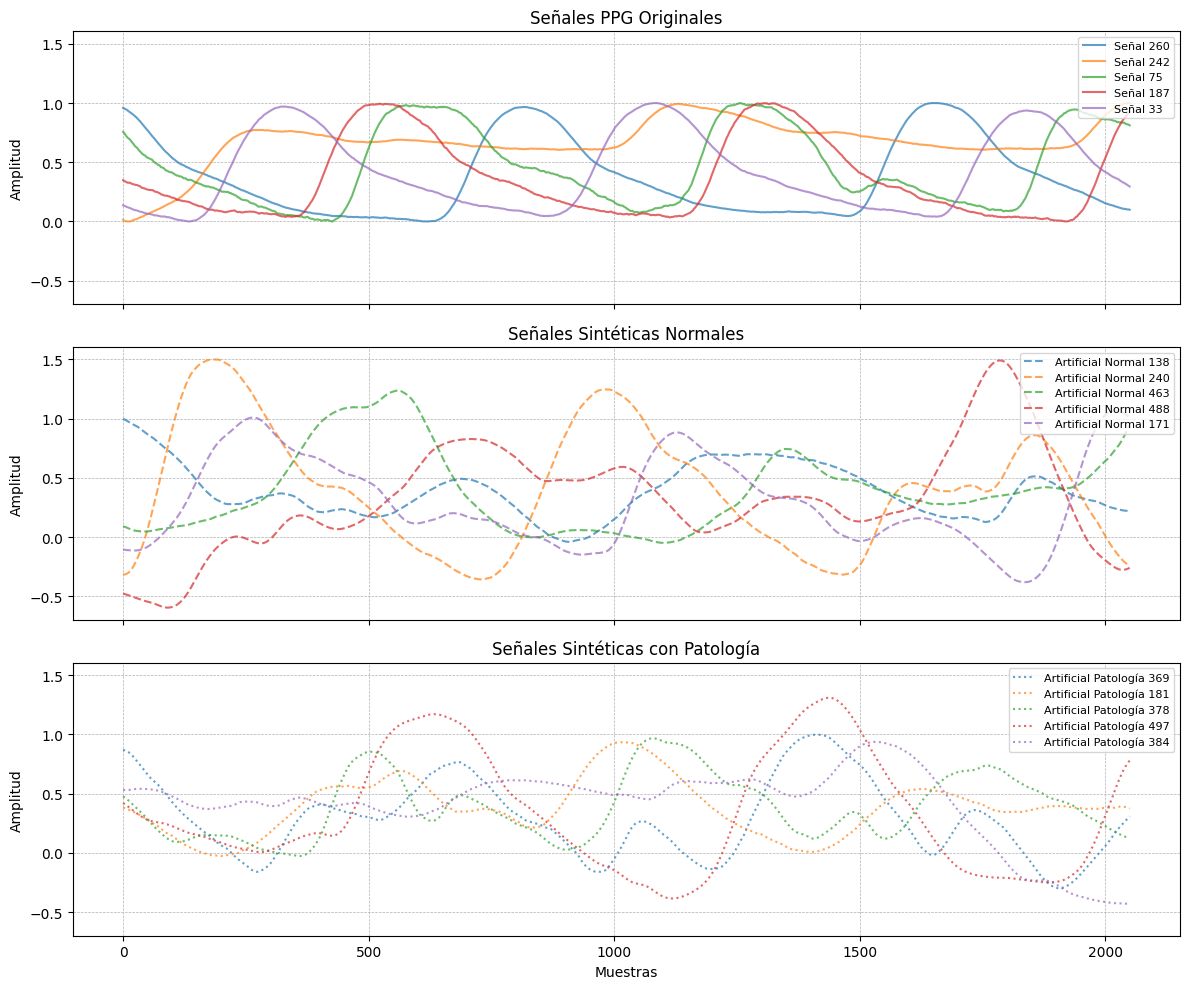

In [156]:
plot_original_vs_synthetic(ppg_signals, synthetic_signals_normal, synthetic_signals_pathology, num_samples=5)

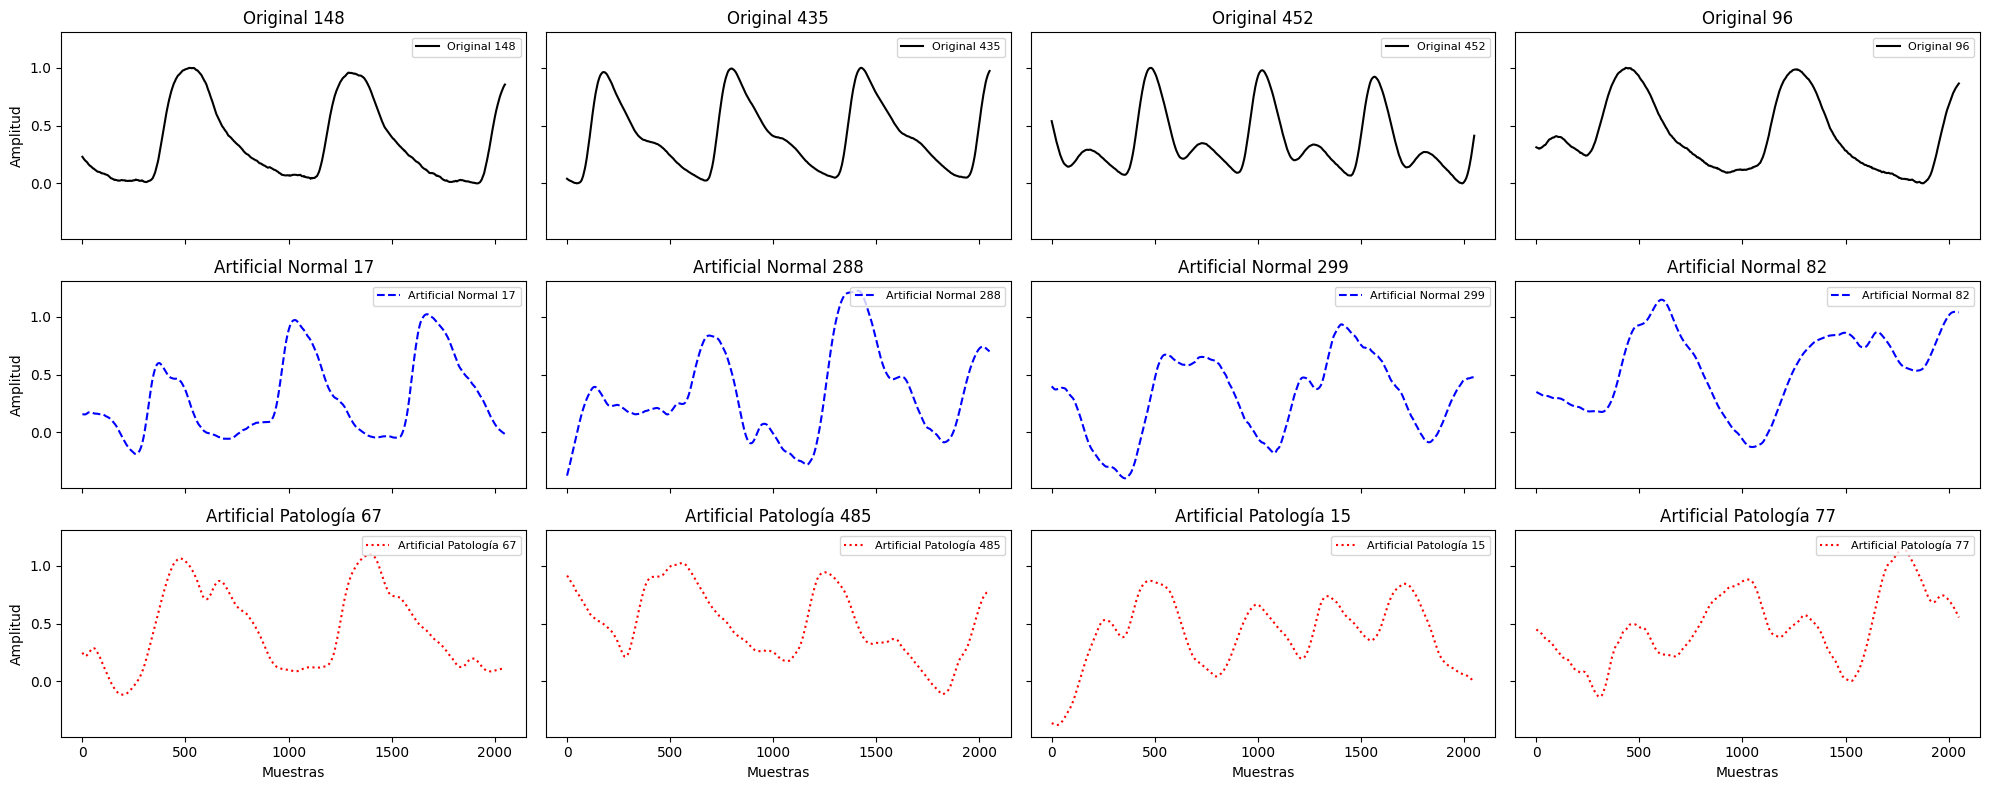

In [157]:
plot_separate_signals(ppg_signals, synthetic_signals_normal, synthetic_signals_pathology, num_samples=4)

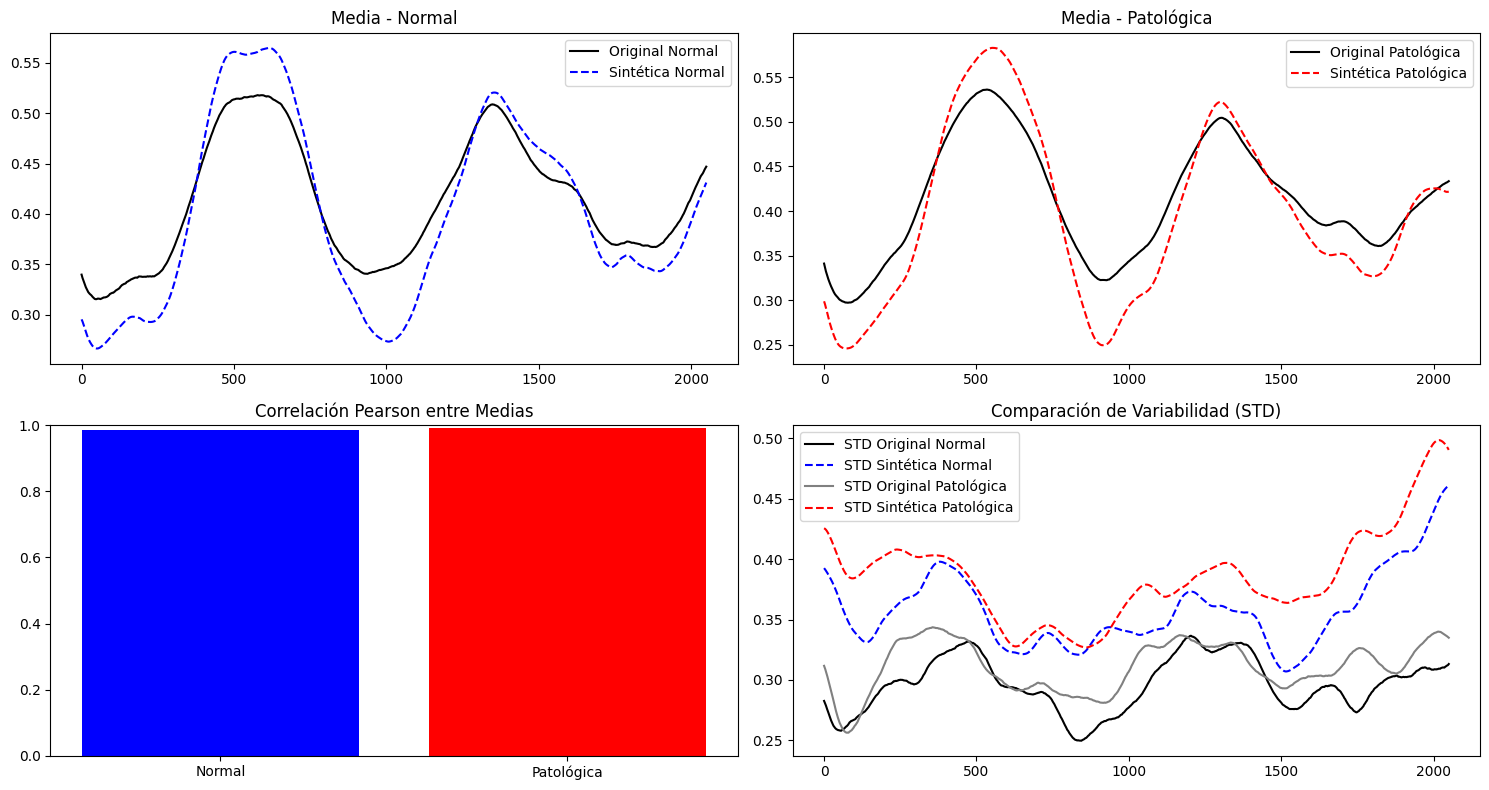

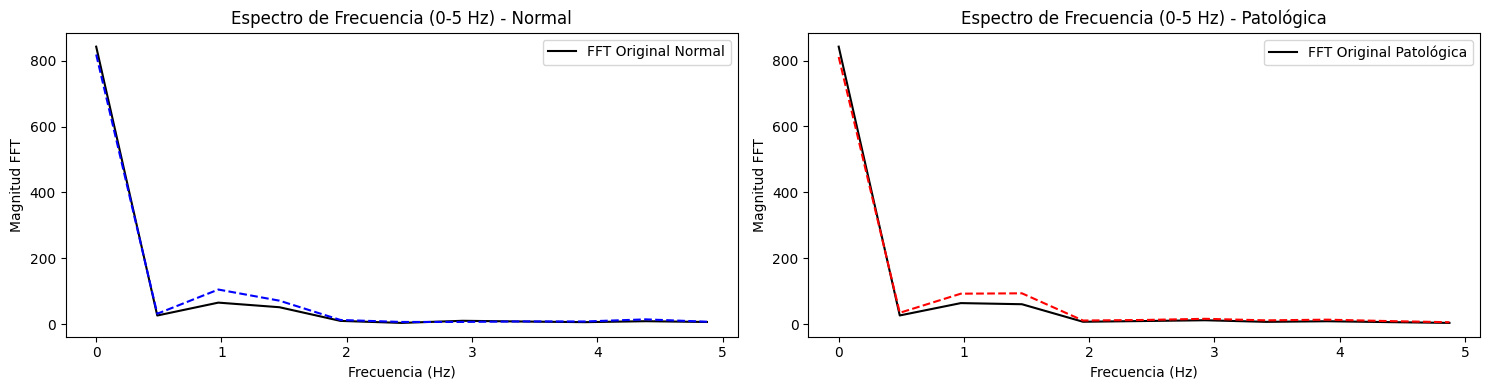

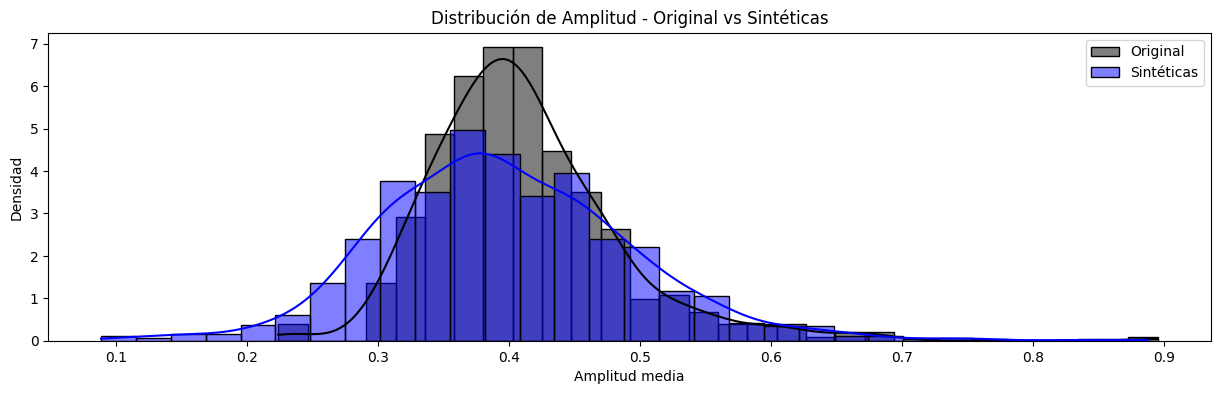

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.fftpack import fft
import seaborn as sns

y_labels_np = y_labels.to_numpy()
# Separar se√±ales normales y patol√≥gicas seg√∫n etiquetas
original_signals_normal = ppg_signals[y_labels_np == True]
original_signals_pathology = ppg_signals[y_labels_np == False]

synthetic_signals_normal = np.array(synthetic_signals_normal)
synthetic_signals_pathology = np.array(synthetic_signals_pathology)

# N√∫mero de muestras en cada se√±al
num_samples = original_signals_normal.shape[1]

# 1Ô∏è‚É£ **Promedio de se√±ales por clase**
mean_original_normal = np.mean(original_signals_normal, axis=0)
mean_original_pathology = np.mean(original_signals_pathology, axis=0)
mean_synthetic_normal = np.mean(synthetic_signals_normal, axis=0)
mean_synthetic_pathology = np.mean(synthetic_signals_pathology, axis=0)

# 2Ô∏è‚É£ **Comparaci√≥n visual de formas de onda representativas**
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

axes[0, 0].plot(mean_original_normal, label="Original Normal", color="black")
axes[0, 0].plot(mean_synthetic_normal, label="Sint√©tica Normal", linestyle="dashed", color="blue")
axes[0, 0].set_title("Media - Normal")
axes[0, 0].legend()

axes[0, 1].plot(mean_original_pathology, label="Original Patol√≥gica", color="black")
axes[0, 1].plot(mean_synthetic_pathology, label="Sint√©tica Patol√≥gica", linestyle="dashed", color="red")
axes[0, 1].set_title("Media - Patol√≥gica")
axes[0, 1].legend()

# 3Ô∏è‚É£ **Correlaci√≥n entre se√±ales originales y sint√©ticas**
corr_normal, _ = pearsonr(mean_original_normal, mean_synthetic_normal)
corr_pathology, _ = pearsonr(mean_original_pathology, mean_synthetic_pathology)

axes[1, 0].bar(["Normal", "Patol√≥gica"], [corr_normal, corr_pathology], color=["blue", "red"])
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_title("Correlaci√≥n Pearson entre Medias")

# 4Ô∏è‚É£ **An√°lisis de variabilidad (Desviaci√≥n est√°ndar)**
std_original_normal = np.std(original_signals_normal, axis=0)
std_original_pathology = np.std(original_signals_pathology, axis=0)
std_synthetic_normal = np.std(synthetic_signals_normal, axis=0)
std_synthetic_pathology = np.std(synthetic_signals_pathology, axis=0)

axes[1, 1].plot(std_original_normal, label="STD Original Normal", color="black")
axes[1, 1].plot(std_synthetic_normal, label="STD Sint√©tica Normal", linestyle="dashed", color="blue")
axes[1, 1].plot(std_original_pathology, label="STD Original Patol√≥gica", color="grey")
axes[1, 1].plot(std_synthetic_pathology, label="STD Sint√©tica Patol√≥gica", linestyle="dashed", color="red")
axes[1, 1].set_title("Comparaci√≥n de Variabilidad (STD)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 5Ô∏è‚É£ **Comparaci√≥n de espectros de frecuencia (FFT) en el rango de 0-5 Hz**
freqs = np.fft.fftfreq(num_samples, d=1/1000)  # Asumiendo muestreo a 1 kHz
fft_original_normal = np.abs(fft(mean_original_normal))
fft_synthetic_normal = np.abs(fft(mean_synthetic_normal))
fft_original_pathology = np.abs(fft(mean_original_pathology))
fft_synthetic_pathology = np.abs(fft(mean_synthetic_pathology))

# Filtrar frecuencias entre 0 y 10 Hz
low_freq_mask = (freqs >= 0) & (freqs <= 5)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(freqs[low_freq_mask], fft_original_normal[low_freq_mask], label="FFT Original Normal", color="black")
axes[0].plot(freqs[low_freq_mask], fft_synthetic_normal[low_freq_mask], linestyle="dashed", color="blue")
axes[0].set_title("Espectro de Frecuencia (0-5 Hz) - Normal")
axes[0].set_xlabel("Frecuencia (Hz)")
axes[0].set_ylabel("Magnitud FFT")
axes[0].legend()

axes[1].plot(freqs[low_freq_mask], fft_original_pathology[low_freq_mask], label="FFT Original Patol√≥gica", color="black")
axes[1].plot(freqs[low_freq_mask], fft_synthetic_pathology[low_freq_mask], linestyle="dashed", color="red")
axes[1].set_title("Espectro de Frecuencia (0-5 Hz) - Patol√≥gica")
axes[1].set_xlabel("Frecuencia (Hz)")
axes[1].set_ylabel("Magnitud FFT")
axes[1].legend()

plt.tight_layout()
plt.show()

# 6Ô∏è‚É£ **Distribuci√≥n de amplitudes originales vs sint√©ticas**
mean_original = np.mean(original_signals_normal, axis=1).tolist() + np.mean(original_signals_pathology, axis=1).tolist()
mean_synthetic = np.mean(synthetic_signals_normal, axis=1).tolist() + np.mean(synthetic_signals_pathology, axis=1).tolist()

plt.figure(figsize=(15, 4))
sns.histplot(mean_original, bins=30, alpha=0.5, label="Original", color='black', kde=True, stat='density')
sns.histplot(mean_synthetic, bins=30, alpha=0.5, label="Sint√©ticas", color='blue', kde=True,stat='density')
plt.xlabel("Amplitud media")
plt.ylabel("Densidad")
#plt.ylim((0,500))
plt.legend()
plt.title("Distribuci√≥n de Amplitud - Original vs Sint√©ticas")
plt.show()


In [159]:
# Guardar en un archivo
with open("./Datasets/China/X_train_China_Augmented.pkl", "wb") as archivo:
    pickle.dump(updated_signals_df.values, archivo)

with open("./Datasets/China/y_train_China_Augmented.pkl", "wb") as archivo:
    pickle.dump(updated_labels_series, archivo)